In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import xml.etree.ElementTree as ET
import copy
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [2]:
# import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
# import torchvision
from torch.utils.data import Dataset


In [3]:
room_dict = {'bathroom': 0, 'bedroom': 1, 'dining room': 2, 'kitchen': 3, 'stairs': 4}

In [13]:
### process every xml files to be 'filename':[[xmin_room1,xmax_room1,ymin_room1,ymax_room1,label_room1],
### [xmin_room2,xmax_room2,ymin_room2,ymax_room2,label_room2],...]

directName = "./data_2"
script_dict = {}   ### record of each figure and each room of it
room_count = {0:0, 1:0, 2:0, 3:0, 4:0}
xy_dist = []
for file in os.listdir(directName):
    if file.endswith(".xml"):
        fileNamePre = file[:-4]
        tree = ET.parse(os.path.join(directName, file))
        root = tree.getroot()
        script_dict[fileNamePre] = []
        for item in root.findall('object'):
            rooms = [None]*5
            for child in item:
                if(child.tag == 'name'):
                    room_type = child.text
                    room_type_digit = -1
                    if(not (room_type in room_dict)):
                        continue

                    room_count[room_dict[room_type]] += 1
                    rooms[4] = room_dict[room_type]
                elif(child.tag == 'bndbox'):
                    for grandchild in child:
                        if grandchild.tag=='xmin':
                            rooms[0] = int(grandchild.text)
                        elif grandchild.tag=='xmax':
                            rooms[1] = int(grandchild.text)
                        elif grandchild.tag=='ymin':
                            rooms[2] = int(grandchild.text)
                        elif grandchild.tag=='ymax':
                            rooms[3] = int(grandchild.text)
            
            if(rooms[4] in range(6)):
                xy_dist.append(rooms[1]-rooms[0])
                xy_dist.append(rooms[3]-rooms[2])
                script_dict[fileNamePre].append(rooms)

In [5]:
room_dict

{'bathroom': 0, 'bedroom': 1, 'dining room': 2, 'kitchen': 3, 'stairs': 4}

In [15]:
def split_rooms_coords_rot(directName, script_dict, resize_scale, test_ratio):
    X_cor = []
    Y_cor = []
    count = [0]*6
    for file in os.listdir(directName): 
        if file.endswith(".xml"):
            fileNamePre = file[:-4]
            filePath = os.path.join(directName, fileNamePre+'.png')
            img = cv2.imread(filePath, cv2.IMREAD_GRAYSCALE)
            coords = script_dict[fileNamePre]
            for cor in coords:
                if(cor[4]==9 or count[cor[4]]>=100):
                    continue
                count[cor[4]] += 1
                img_part = img[cor[2]:cor[3],cor[0]:cor[1]]
                img_part = cv2.resize(img_part, (resize_scale,resize_scale))
                X_cor.append(img_part)
                Y_cor.append(cor[4])
                X_cor.append(np.rot90(img_part,1))  ## rotate 90 degree
                Y_cor.append(cor[4])
                X_cor.append(np.rot90(img_part,2))  ## rotate 180 degree
                Y_cor.append(cor[4])
                X_cor.append(np.rot90(img_part,3))  ## rotate 180 degree
                Y_cor.append(cor[4])
 
    X_cor = np.array(X_cor)
    Y_cor = np.array(Y_cor)
    X, y = shuffle(X_cor, Y_cor, random_state=0)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio, random_state=42)
    return X_train, X_test, y_train, y_test   

In [16]:
X_train, X_test, y_train, y_test = split_rooms_coords_rot(directName, script_dict, 50, 0.1)

In [17]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
print(X_train.nbytes*1e-9, X_test.nbytes*1e-9, y_train.nbytes*1e-9, y_test.nbytes*1e-9)


(1720, 50, 50) (192, 50, 50) (1720,) (192,)
0.0043 0.00048 6.88e-06 7.680000000000001e-07


In [18]:
batch_size = 120
momentum = 0.9
lr = 0.01
epochs = 10
log_interval = 6
nclasses = len(room_dict)

In [19]:
class MyDataset(Dataset):

    def __init__(self, X, y):

        self.X = torch.from_numpy(np.expand_dims(X, axis=1).astype(np.float32))
#         self.y = torch.from_numpy(y.astype(np.float32).reshape([-1,1]))
        self.y = torch.from_numpy(y.reshape([-1,1]).squeeze(1)).long()
    
    def __len__(self):
        return self.X.size(0)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


train_dataset = MyDataset(X_train, y_train)
test_dataset = MyDataset(X_test, y_test)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=True, num_workers=0)


In [21]:
## test 50% accuracy
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 30, kernel_size=5)
        self.conv3 = nn.Conv2d(30, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(80, nclasses)
        self.batchNorm1 = nn.BatchNorm2d(10)
        self.batchNorm2 = nn.BatchNorm2d(30)
        self.batchNorm3 = nn.BatchNorm2d(20)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = self.batchNorm1(x)
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = self.batchNorm2(x)
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv3(x)), 2))
        x = self.batchNorm3(x)
        x = x.view(-1, 80)
        x = F.relu(self.fc1(x))
        return F.log_softmax(x,dim=1)

In [22]:
model = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

In [23]:
def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
#         loss = F.nll_loss(output, target)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [24]:
def test():
    model.eval()
    
    test_loss = 0
    correct = 0
    for data, target in train_loader:
        #data, target = Variable(data, volatile=True), Variable(target)
        output = model(data)
        test_loss += F.cross_entropy(output, target, reduction='sum').item() # sum up batch loss
        #test_loss += F.cross_entropy(output, target, sum=True).item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(train_loader.dataset)
    print('\nTrain set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(train_loader.dataset),
        100. * correct / len(train_loader.dataset)))
    train_loss = test_loss
    train_correct = correct
    
    
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        #data, target = Variable(data, volatile=True), Variable(target)
        output = model(data)
        test_loss += F.cross_entropy(output, target, reduction='sum').item() # sum up batch loss
        #test_loss += F.cross_entropy(output, target, sum=True).item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    return train_loss, test_loss, train_correct / len(train_loader.dataset), correct / len(test_loader.dataset)

In [ ]:
train_loss_hist = []
test_loss_hist = []
train_correct_hist = []
test_correct_hist = []
for epoch in range(40):
    train(epoch)
    train_loss, test_loss, train_correct, test_correct = test()
    train_loss_hist.append(train_loss)
    test_loss_hist.append(test_loss)
    train_correct_hist.append(train_correct)
    test_correct_hist.append(test_correct)

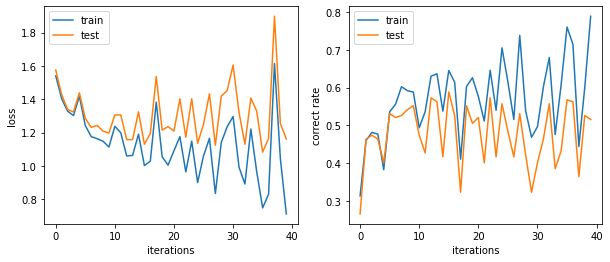

In [26]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(train_loss_hist)
plt.plot(test_loss_hist)
plt.xlabel('iterations')
plt.ylabel('loss')
plt.legend(['train','test'])


plt.subplot(1,2,2)
plt.plot(train_correct_hist)
plt.plot(test_correct_hist)
plt.xlabel('iterations')
plt.ylabel('correct rate')
plt.legend(['train','test'])